# 2. NESTML synapse model

---

## 2.1 STDP synapse

In this tutorial we will plot the "window function", which relates the weight change of a synapse to the timing between the pre and postsynaptic spikes. This type of plasticity rule i s also knwon as spike-timing dependent plasticity (STDP).

Many experimental findings have shown that synaptic strength changes as a function of the spike timing between presynaptic and postsynaptic neurons. If the presynaptic neurons fires before the postsynapic one, the synapse is strengthened and promoting facilitation. Conversely, if the postsynaptic neuron fires before the presynaptic, the synapse is weakened, thus leading to depression. The closer the spikes are, the stronger is the facilitation or depression.

Following [1], the theoretical model for the STDP rule is as follows:

$$
\Delta^{\pm}w = \pm \lambda \cdot f_{\pm}(w) \cdot K(|t_o - t_i|).
$$

A pair of spikes in the input and output cells, of times $t_o$ and $t_i$ respectively, induces a change $\Delta w$ in the weight $w$ based on the timing between $t_o$ and $t_i$: the weight is increased by $\Delta^{+}w$ if $t_o \gt t_i$, and decreased by $\Delta^{-}w$ if $t_o \lt t_i$. The temporal dependence is defined by the filter kernel $K$ which is taken to be:

$$
K(t) = exp(-t/\tau).
$$

The coefficient $\lambda$ sets the scale of the synaptic change at each update. The factors $f_{\pm}$ determine the relative magnitude of the changes inthe positive and negative directions, and are set to be: $f_+(w) = 1$ and $f_-(w) = \alpha$, with $\alpha \gt 0$ controlling the asymmetry between potentiation and depression.

To implement the kernel, two extra variables are used: $tr_{pre}$ and $tr_{post}$, which keep track of recent spiking activity. These traces are incremented by 1 whenever a spike occurs, and decay exponentially back to zero. They are computed as the convolution between the exponential kernel and the spike train:

$$
tr_{pre} = K * \sum_i \delta_{pre,i}
$$

$$
tr_{post} = K * \sum_i \delta_{post,i}
$$

The update rules are implemented in the 'onReceive' blocks, which excecutes commands when pre or postsynaptic spikes occur. In the case of facilitation, the update rule is:

$$
\Delta^+ w = \lambda \cdot tr_{pre},
$$

while the rule for depression is:

$$
\Delta^- w = -\alpha \cdot \lambda \cdot tr_{pre}
$$

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import nest
import numpy as np
from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: May  5 2025 12:54:52

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## 2.2 Writing and building the NESTML model

In [10]:
stdp_model = """
model stdp_synapse:

    parameters:
        d ms = 1 ms
        lambda real = .01
        tau_tr_pre ms = 20 ms
        tau_tr_post ms = 20 ms
        alpha real = 1

    state:
        w real = 1.

    equations:
        kernel pre_trace_kernel = exp(-t / tau_tr_pre)
        inline pre_trace real = convolve(pre_trace_kernel, pre_spikes)

        # all-to-all trace of postsynaptic neuron
        kernel post_trace_kernel = exp(-t / tau_tr_post)
        inline post_trace real = convolve(post_trace_kernel, post_spikes)

    input:
        pre_spikes <- spike
        post_spikes <- spike

    output:
        spike(weight real, delay ms)

    onReceive(post_spikes):
        # potentiate synapse
        w += lambda * pre_trace

    onReceive(pre_spikes):
        # depress synapse
        w -= alpha * lambda * post_trace

        # deliver spike to postsynaptic partner
        emit_spike(w, d)

    update:
        integrate_odes()
"""


neuron_model = """
model izhikevich_neuron:
    parameters:
        a real = 0.02             # Describes time scale of recovery variable
        b real = 0.2              # Sensitivity of recovery variable
        c mV = -65 mV             # After-spike reset value of V_m
        d real = 8.0              # After-spike reset value of U_m
        V_m_init mV = -65 mV      # Initial membrane potential
        V_min mV = -inf * mV      # Absolute lower value for the membrane potential.
        V_th mV = 30 mV           # Threshold potential

        # Constant external input current
        I_e pA = 0 pA

    state:
        V_m mV = V_m_init         # Membrane potential
        U_m real = b * V_m_init   # Membrane potential recovery variable

    equations:
        V_m' = (0.04 * V_m * V_m / mV + 5.0 * V_m + (140 - U_m) * mV + ((I_e + I_stim) * GOhm)) / ms
        U_m' = a * (b * V_m - U_m * mV) / (mV * ms)

    input:
        spikes <- spike
        I_stim pA <- continuous

    output:
        spike

    update:
        integrate_odes()

        # Add synaptic current
        V_m += spikes * mV * s

        # lower bound of membrane potential
        V_m = max(V_min, V_m)

    onCondition(V_m >= V_th):
        # threshold crossing
        V_m = c
        U_m += d
        emit_spike()
"""

In [11]:
module_name, neuron_model_name, synapse_model_name = \
    NESTCodeGeneratorUtils.generate_code_for(neuron_model,
                                             stdp_model,
                                             post_ports=["post_spikes"],
                                             logging_level="WARNING",
                                             codegen_opts={"delay_variable": {"stdp_synapse": "d"},
                                                           "weight_variable": {"stdp_synapse": "w"}})


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: May  5 2025 12:54:52

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

[13,izhikevich_neuron_nestml, WARNING, [4:8;4:17]]: Variable 'a' has the same name as a physical unit!
[14,izhikevich_neuron_nestml, WARNING, [7:8;7:17]]: Variable 'd' has the same name as a physical unit!
[17,stdp_synapse_nestml, WARNING, [5:8;5:17]]: Variable 'd' has the same name as a physical unit!


## 2.3 Running the simulation

In [31]:
sim_time = 1000
spike_pre = [300, 800]
spike_post = range(1, sim_time-100, 5)
delay = 10
dt = []
dw = []

for spike in spike_post:
    nest.ResetKernel()
    nest.Install(module_name)

    sg_pre = nest.Create("spike_generator", params={"spike_times": spike_pre})
    sg_post = nest.Create("spike_generator", params={"spike_times": [spike]})

    pre_neuron = nest.Create("parrot_neuron")
    post_neuron = nest.Create(neuron_model_name)

    sr_pre = nest.Create("spike_recorder")
    sr_post = nest.Create("spike_recorder")

    nest.Connect(sg_pre, pre_neuron)
    nest.Connect(sg_post, post_neuron, syn_spec={"weight": 9999.0})
    nest.Connect(pre_neuron, sr_pre)
    nest.Connect(post_neuron, sr_post)
    nest.Connect(pre_neuron, post_neuron, syn_spec={"synapse_model": synapse_model_name, "delay": delay})


    syn = nest.GetConnections(source=pre_neuron, synapse_model=synapse_model_name)
    initial_weight = nest.GetStatus(syn)[0]["w"]
    l = nest.GetDefaults(synapse_model_name)["lambda"]

    nest.Simulate(sim_time)

    updated_weight = nest.GetStatus(syn)[0]["w"]

    t_pre_spike = sr_pre.get()["events"]["times"][0]
    t_post_spike = sr_post.get()["events"]["times"][0]

    dt.append(t_post_spike - t_pre_spike)
    dw.append((updated_weight - initial_weight)/l)


Aug 07 15:17:15 Install [Info]: 
    loaded module nestml_f431677534384388b42b964244fefda6_module

Aug 07 15:17:15 NodeManager::prepare_nodes [Info]: 
    Preparing 6 nodes for simulation.

Aug 07 15:17:15 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 6
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Aug 07 15:17:15 SimulationManager::run [Info]: 
    Simulation finished.

Aug 07 15:17:15 Install [Info]: 
    loaded module nestml_f431677534384388b42b964244fefda6_module

Aug 07 15:17:15 NodeManager::prepare_nodes [Info]: 
    Preparing 6 nodes for simulation.

Aug 07 15:17:15 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 6
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Aug 07 15:17:15 SimulationManager::run [Info]: 
    Simulation finished.

Aug 07 15:17:15 Install [Info]: 
    loaded module nestml_f431677534384388b42b964244fefda6_module

Aug 07 15:17:15 NodeManager::p

## 2.4 Plotting the STDP window function

Text(0, 0.5, '$\\Delta w$')

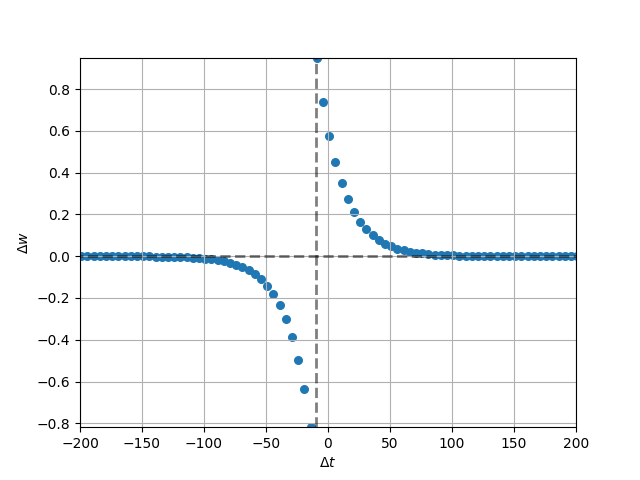

In [33]:
plt.figure()
plt.scatter(dt, dw, s=30)
plt.grid()
plt.plot((np.min(dt), np.max(dt)), (0, 0), color='k', linestyle="--", linewidth=2, alpha=0.5)
plt.plot((-delay, -delay), (np.min(dw), np.max(dw)), color='k', linestyle="--", linewidth=2, alpha=0.5)
plt.xlim((-200, 200))
plt.ylim((np.min(dw), np.max(dw)))
plt.xlabel(r"$\Delta t$")
plt.ylabel(r"$\Delta w$")